<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


plot prior

course cluster

one species warm start

# Preparation

In [1]:
%cd ../RADOM

# restrict numpy to use only one core, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import cmasher as cmr
import copy

In [104]:
def entropy(X):
    """
    Shannon entropy of the empirical distributions for each gene
    """
    n,p,s = X.shape
    entropy = np.zeros(p)
    for j in range(p):
        for k in range(s):
            x=X[:,j,k]
            value,counts = np.unique(x, return_counts=True)
            norm_counts = counts / counts.sum()
            entropy[j] -= (norm_counts * np.log(norm_counts)).sum()
    return entropy

In [246]:
from scipy.special import gammaln
from scipy.stats import chi2, poisson
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


def select_genes(adata,r=None,n_genes=30):
    """
    Perform G test of Poisson fits and select n_genes with highest G-test statistic
    """
    idx = (adata.layers["unspliced"].toarray().mean(0) > 0) & (adata.layers["spliced"].toarray().mean(0) > 0)
    X=np.zeros((n,idx.sum(),2))
    X[:,:,0]=adata.layers["unspliced"][:,idx].toarray()
    X[:,:,1]=adata.layers["spliced"][:,idx].toarray()
    Y = np.mean(X,axis=0,keepdims=True)
    if r is None:
        logL = np.sum(poisson.logpmf(k=X,mu=Y),axis=(0,2))
    else:
        logL = np.sum(poisson.logpmf(k=X,mu=r[:,None,None]*Y),axis=(0,2))
    #logL = np.sum(X*np.log(r[:,None,None]*Y)-r[:,None,None]*Y-gammaln(X+1),axis=(0,2))
    negG = logL + n*entropy(X)
    p_value = 1-chi2.cdf(-2*negG,df=n-1)
    selected_genes = adata.var_names[idx][np.argsort(negG)[:n_genes]]
    adata.var['e logL'] = np.nan
    adata.var['Poisson logL'] = np.nan
    adata.var['p value'] = np.nan
    adata.var['e logL'][idx] = -n*entropy(X)
    adata.var['Poisson logL'][idx] = logL
    adata.var['p value'][idx] = p_value
    return selected_genes

## Load data

In [3]:
import scanpy

adata = scanpy.read('../data/hgForebrainGlut.loom')
adata.var_names_make_unique
adata

/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [4]:
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
print(Clusters)
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
cell_colors = colors20[np.mod(clusters, 20)]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", colors20[:7], N=7)

{0, 1, 2, 3, 4, 5, 6}


/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


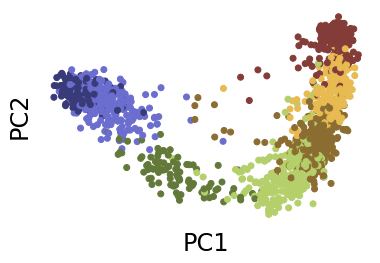

In [350]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X/total_UMI[:,None]*np.mean(total_UMI)))

fig, ax = plt.subplots(1,1)
ax.scatter(-x[:,0],-x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

# Select genes

In [351]:
known_marker_genes=["SOX2","SLC17A7","EOMES"]
novel_marker_genes=["CLU","FBXO32","UNC5D","SEZ6","RBFOX1"]
their_genes=["DCX","GRIA3","STMN2", "FAM64A","ELAVL4","RNASEH2B"]
marker_genes = known_marker_genes + novel_marker_genes + their_genes
marker_idx=adata.var_names.isin(marker_genes)

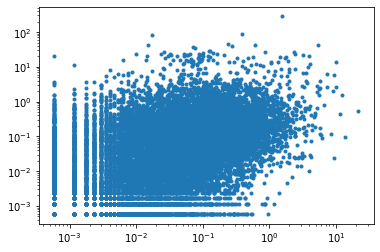

In [352]:
S_mean = adata.layers["spliced"].toarray().mean(axis=0)
U_mean = adata.layers["unspliced"].toarray().mean(axis=0)
plt.loglog(U_mean,S_mean,'.');

In [353]:
idx = (adata.layers["unspliced"].toarray().mean(0)>0) & (adata.layers["spliced"].toarray().mean(0)>0) 
X=np.zeros((n,idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,idx].toarray()
gene_list=adata.var_names[idx]
Y = np.mean(X,axis=0,keepdims=True)
#logL = np.sum(X*np.log(Y)-Y-gammaln(X+1),axis=(0,2))
logL = np.sum(X*np.log(r[:,None,None]*Y)-r[:,None,None]*Y-gammaln(X+1),axis=(0,2))
negG = logL + n*entropy(X)

In [354]:
p_value = 1-chi2.cdf(-2*negG,df=n-1)

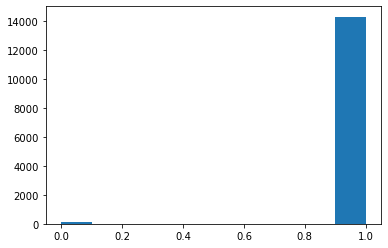

In [355]:
plt.hist(p_value);

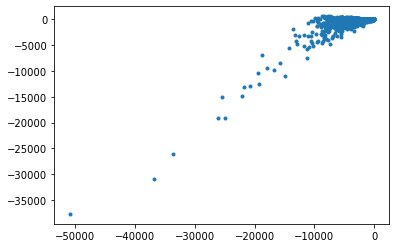

In [349]:
plt.plot(logL,negG,'.')

In [293]:
gene_list=select_genes(adata,r=r,n_genes=31)

In [294]:
gene_list

Index(['MALAT1', 'VIM', 'RBFOX1', 'FABP7', 'FOS', 'TUBA1A', 'PTN', 'CNTNAP2',
       'STMN2', 'NRG1', 'OPCML', 'TMSB10', 'SOX4', 'TMSB4X', 'PTPRD', 'HES1',
       'NFIB', 'NEUROD6', 'SOX5', 'CREB5', 'TUBA1B', 'CCSER1', 'SYT1',
       'LRRTM4', 'LSAMP', 'UNC5D', 'DCC', 'LRRC7', 'HSPB1', 'RTN1', 'AUTS2'],
      dtype='object', name='Gene')

In [295]:
idx = [np.where(adata.var_names == gene)[0][0] for  gene in gene_list]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

plot_mask = gene_list.isin(marker_genes)
plot_idx = np.arange(len(gene_list))[plot_mask]

gene_list[plot_mask]

Index(['RBFOX1', 'STMN2', 'UNC5D'], dtype='object', name='Gene')

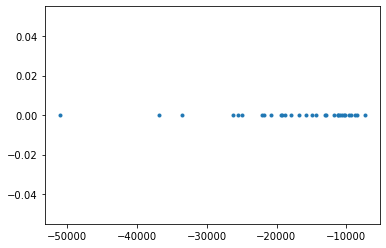

In [296]:
plt.plot(adata.var['Poisson logL'][idx],adata.var['p value'][idx],'.')

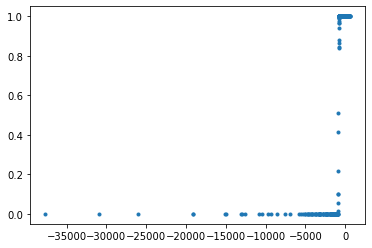

In [297]:
plt.plot(adata.var['Poisson logL']-adata.var['e logL'],adata.var['p value'],'.');

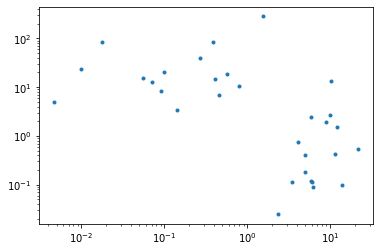

In [298]:
plt.loglog(u.mean(0),s.mean(0),'.');

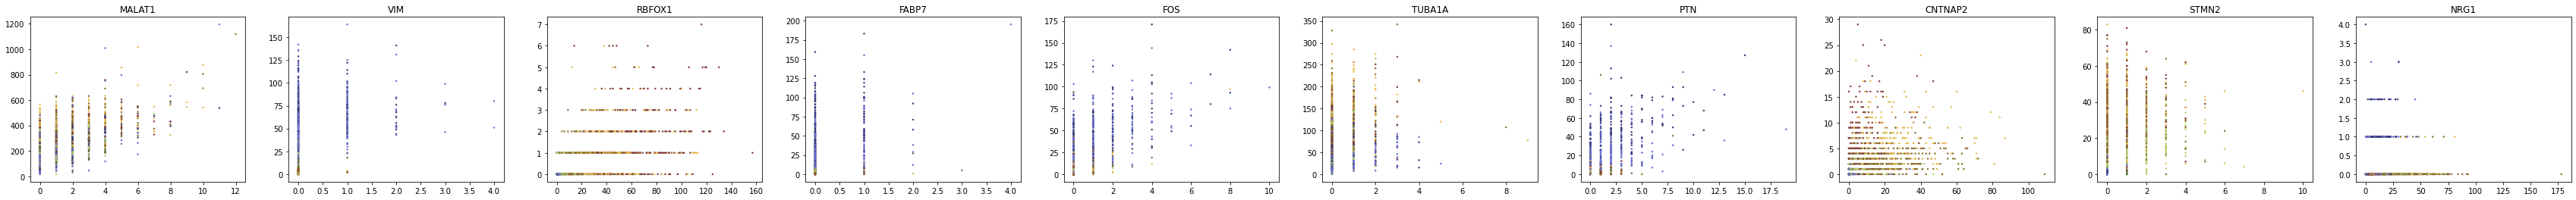

In [299]:
fig, ax = plt.subplots(1,10,figsize=(6*10,4))
for i in range(10):
    ax[i].scatter(u[:,i],s[:,i],c=cell_colors,s=2)
    ax[i].set_title(gene_list[i])

# Fitting

In [300]:
elbos = {}
params={'r':r,"lambda_tau":0.1,"lambda_a":1e-5}

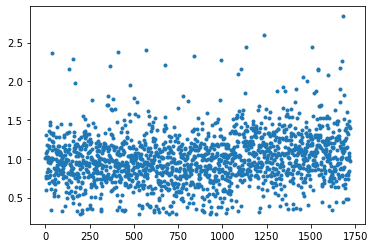

In [301]:
plt.plot(r,'.')

## Random initialization

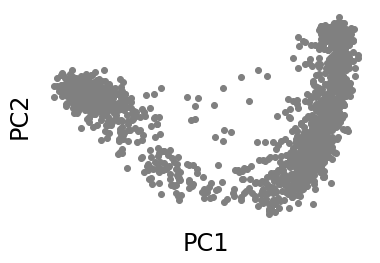

In [302]:
fig, ax = plt.subplots(1,1)
ax.scatter(-x[:,0],-x[:,1],c='grey');
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [321]:
tau=(0,1,2)
topo = np.array([[0,1,2]])
traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=1)
traj = traj.fit(X, params=params, perm_theta=False, beta=1, n_init=10, parallel=True, epoch=10, n_threads=10,seed=0)

run method fit_multi_init
trial 1


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

trial 2



100%|██████████| 10/10 [00:03<00:00,  3.15it/s]

trial 3



100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

trial 4



100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

trial 5



100%|██████████| 10/10 [00:02<00:00,  3.36it/s]

trial 6



100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

trial 7



100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

trial 8



100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

trial 9



100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

trial 10



100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


In [322]:
Y = traj.get_Y_hat(traj.theta,traj.t,traj.tau,traj.topo,traj.params)
logL = np.sum(X[:,None,None,:,:]*np.log(r[:,None,None,None,None]*Y[None,:])-r[:,None,None,None,None]*Y[None,:]-gammaln(X[:,None,None,:,:]+1),axis=(-1))    

In [323]:
logL.shape

(1720, 1, 100, 31)

In [324]:
gene_logL = np.sum(traj.Q[:,:,:,None]*logL,axis=(0,1,2))/n

In [325]:
Q_entropy = - np.sum(traj.Q*np.log(traj.Q+1e-10))/n

In [326]:
prior_entropy = np.sum(traj.Q*np.log(traj.L*traj.m))/n

In [327]:
gene_logL.sum() 

-156.3326993499324

In [328]:
prior_entropy

4.60517018598809

In [329]:
Q_entropy

0.9716537211090956

In [330]:
gene_logL.sum() - prior_entropy +  Q_entropy

-159.9662158148114

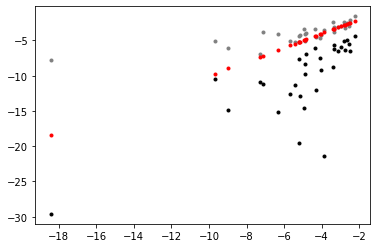

In [331]:
plt.plot(gene_logL,-entropy(X),'.',color='gray')
plt.plot(gene_logL,gene_logL,'.',color='r')
plt.plot(gene_logL,adata.var['Poisson logL'][idx]/n,'k.')

In [332]:
penalty_a = params["lambda_a"] * np.sum((traj.theta[:,1:3]-traj.theta[:,0:2])**2)
penalty_a

0.21274736912917172

In [333]:
gene_logL.sum() - prior_entropy +  Q_entropy - penalty_a

-160.17896318394057

In [334]:
traj.compute_lower_bound(X)

-160.17896336160754

In [335]:
Q, elbo = traj.update_weight(X)
elbo

-160.17896336160754

In [336]:
score = [scores[-1] for scores in traj.elbos]
score

[-163.90955901668764,
 -161.56507856472294,
 -162.60616971246392,
 -166.11292673884228,
 -161.45303374495225,
 -160.17896336160754,
 -163.9048944776133,
 -169.96481387823502,
 -172.39836505121033,
 -163.37806520228543]

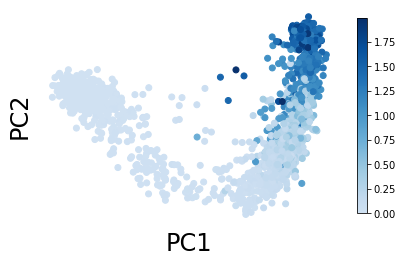

In [337]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

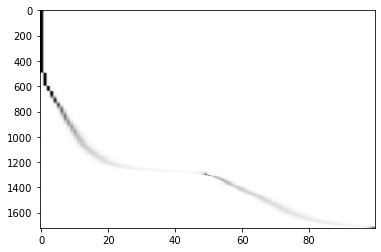

In [338]:
plot_t(traj,order_cells=True);

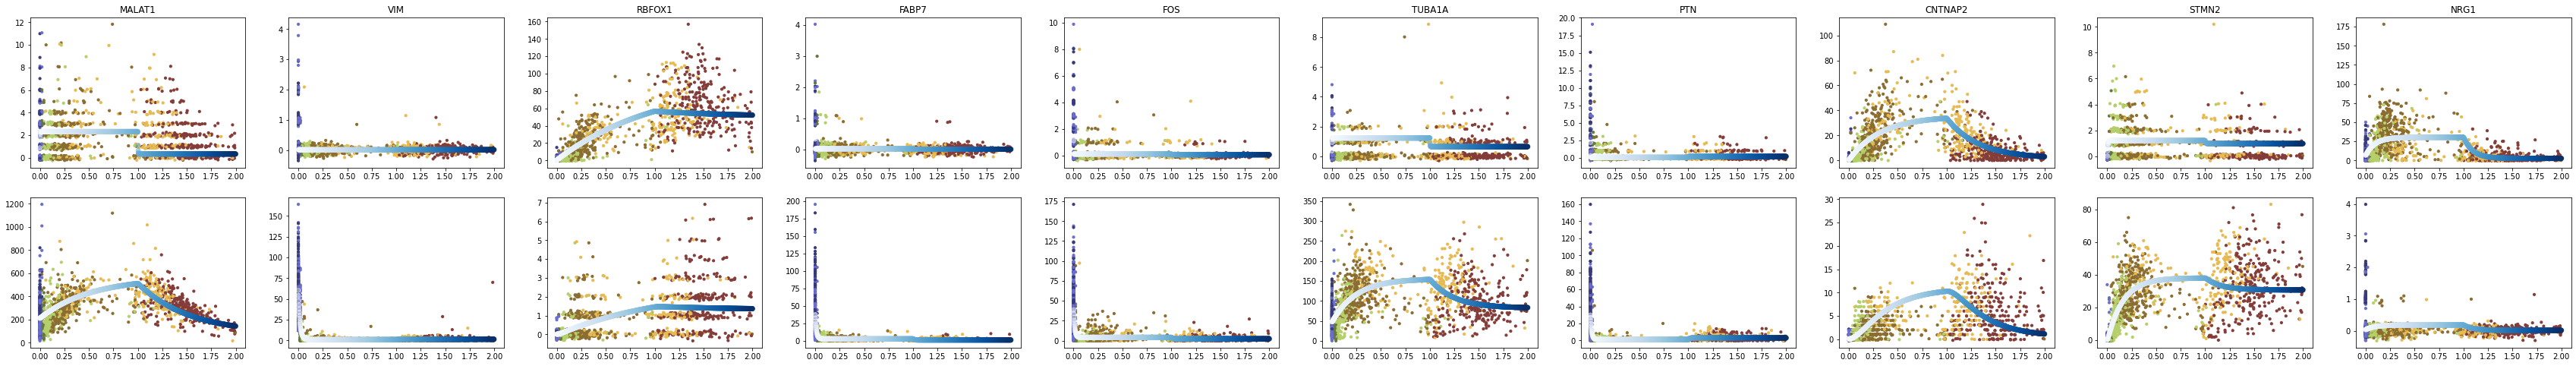

In [339]:
plot_y(traj, X=X,idx=np.arange(10), gene_name=gene_list, cell_colors=cell_colors);

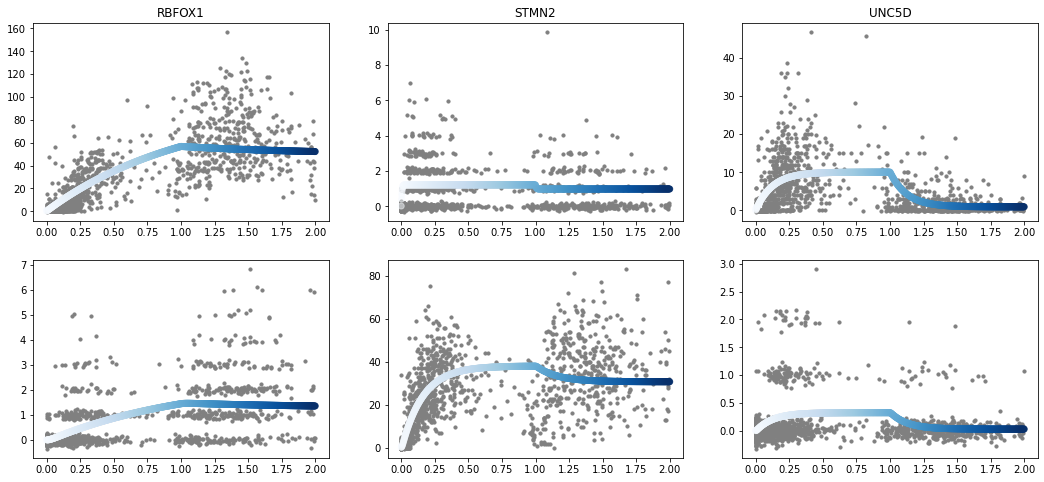

In [340]:
plot_y(traj, X=X, idx=plot_idx, gene_name=gene_list, cell_colors='grey')

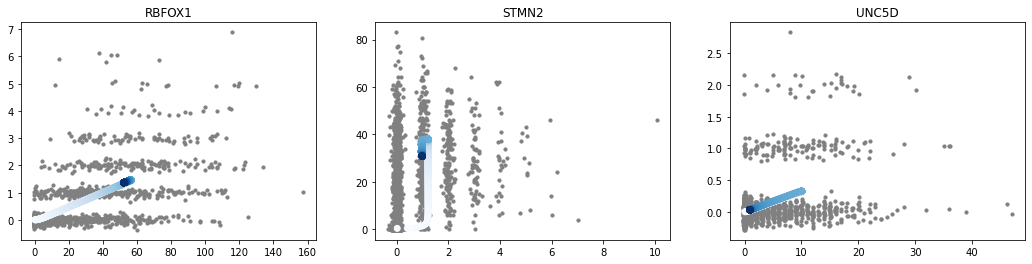

In [341]:
plot_phase(traj, X=X,idx=plot_idx, gene_name=gene_list, cell_colors='grey');

In [208]:
tau=(0,0.3,1,2)
topo = np.array([[0,0,1,2]])
traj_ = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=1)
traj_ = traj_.fit(X, theta=traj.theta, params=params, beta=1, n_init=10, parallel=True, epoch=10, n_threads=10)
traj_.compute_lower_bound(X)

run method fit_warm_start


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


-362.771440311144

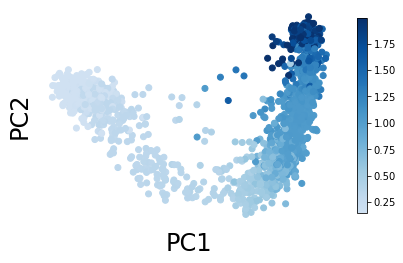

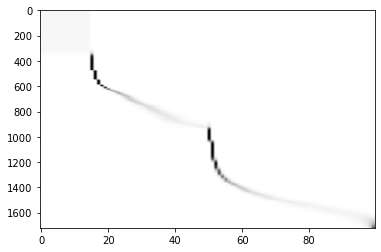

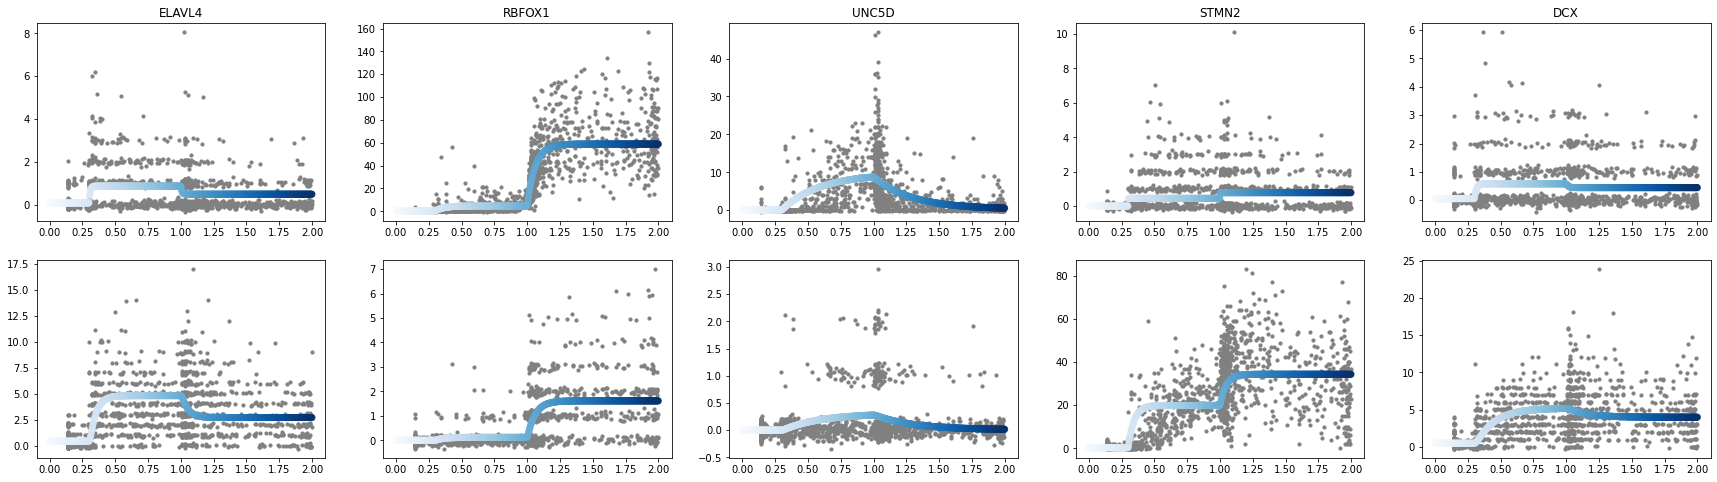

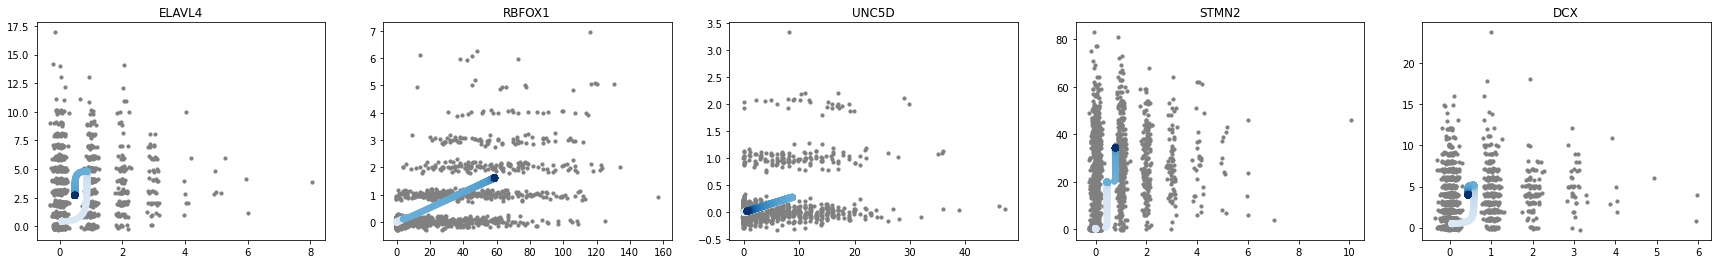

In [209]:
traj_temp = traj_

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(-x[:,0],-x[:,1],c=traj_temp.Q[:,0]@traj_temp.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

plot_t(traj_temp,order_cells=True);

plot_y(traj_temp, X=X,idx=plot_idx, gene_name=gene_list, cell_colors='grey');

plot_phase(traj_temp, X=X,idx=plot_idx, gene_name=gene_list, cell_colors='grey');

### two_species_ss_tau

In [210]:
tau=(0,0.3,1,2)
topo = np.array([[0,0,1,2]])
traj = Trajectory(topo, tau,  model="two_species_ss_tau", restrictions={}, verbose=1)
traj = traj.fit(X, params=params, beta=1, n_init=10, epoch=10, parallel=True, n_threads=10)

run method fit_multi_init
trial 1


100%|██████████| 10/10 [00:41<00:00,  4.18s/it]

trial 2



100%|██████████| 10/10 [00:42<00:00,  4.23s/it]

trial 3



100%|██████████| 10/10 [00:42<00:00,  4.29s/it]

trial 4



100%|██████████| 10/10 [00:41<00:00,  4.10s/it]

trial 5



100%|██████████| 10/10 [00:42<00:00,  4.26s/it]

trial 6



100%|██████████| 10/10 [00:44<00:00,  4.41s/it]

trial 7



100%|██████████| 10/10 [00:42<00:00,  4.28s/it]

trial 8



100%|██████████| 10/10 [00:42<00:00,  4.22s/it]

trial 9



100%|██████████| 10/10 [00:42<00:00,  4.29s/it]

trial 10



100%|██████████| 10/10 [00:42<00:00,  4.24s/it]


In [211]:
traj.compute_lower_bound(X)

-352.7373109143198

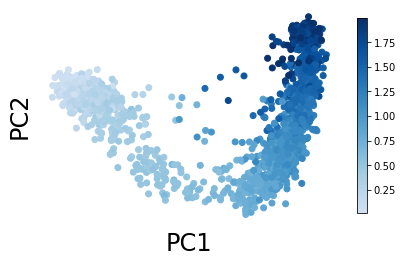

In [212]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

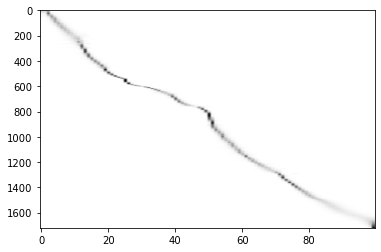

In [213]:
plot_t(traj,order_cells=True);

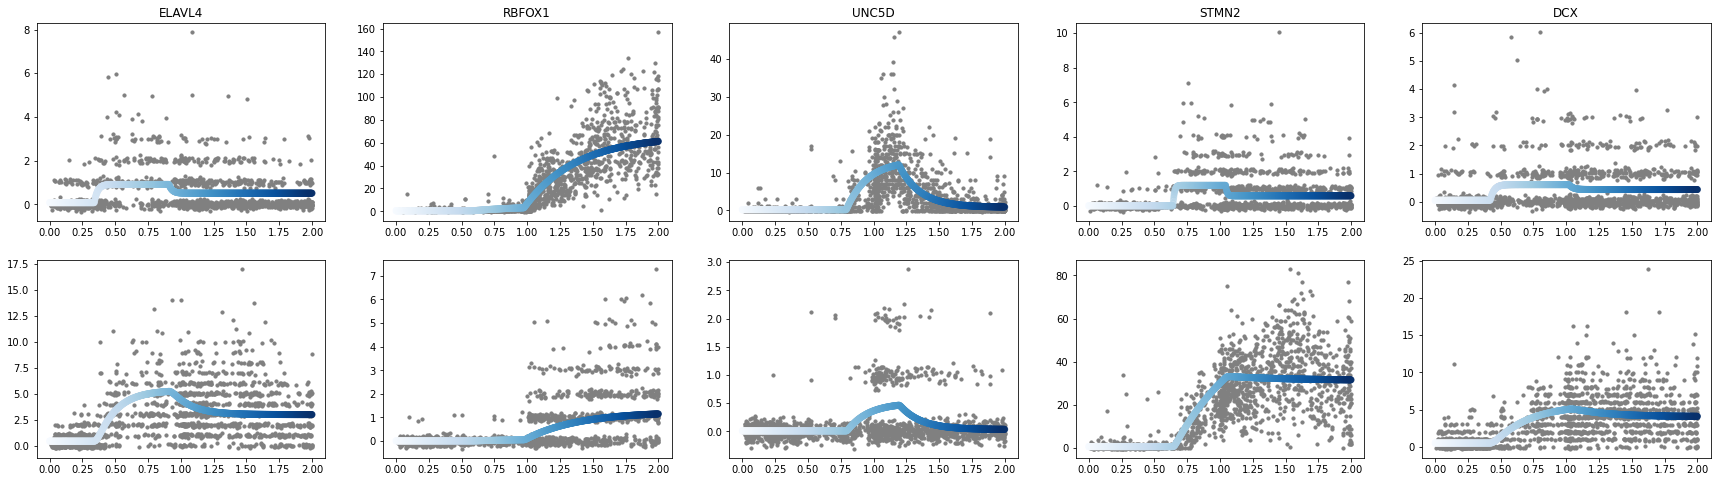

In [214]:
plot_y(traj, X=X, idx=plot_idx, gene_name=gene_list, cell_colors='grey');

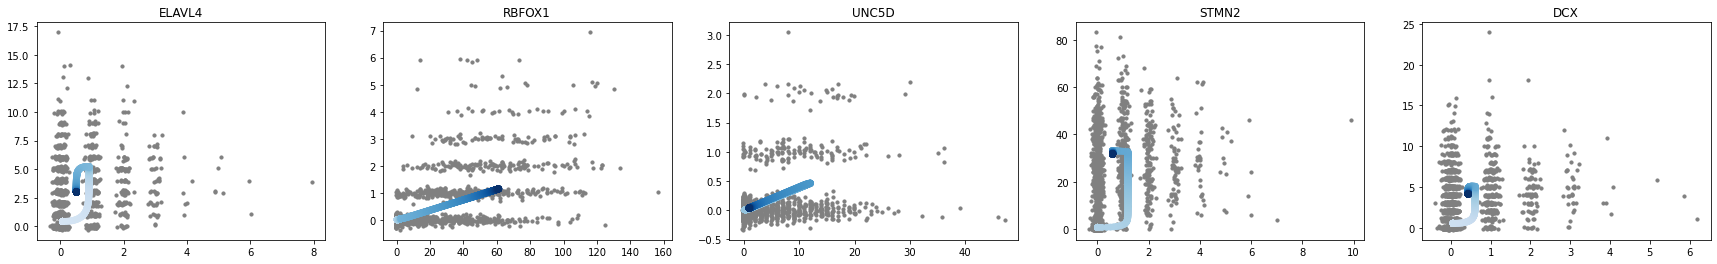

In [216]:
plot_phase(traj, X=X,idx=plot_idx, gene_name=gene_list, cell_colors='grey');

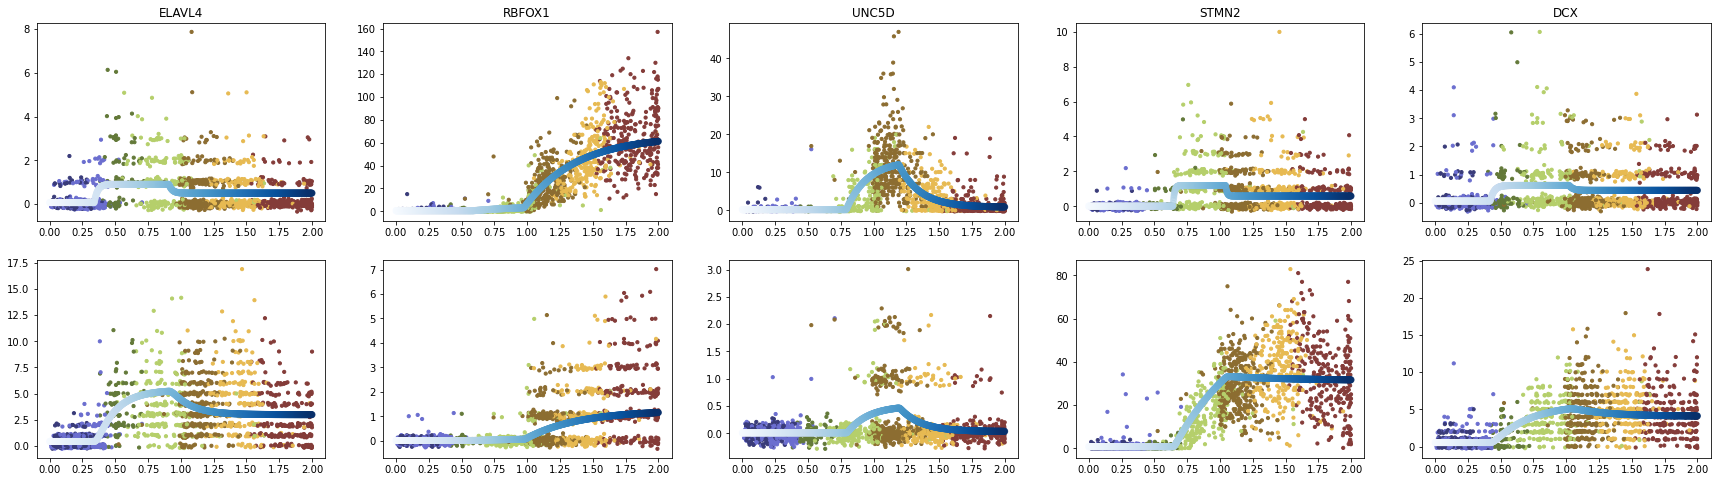

In [217]:
plot_y(traj, X=X, idx=plot_idx, gene_name=gene_list, cell_colors=cell_colors);

### Try different seeds

#### two_species_ss

100%|██████████| 5/5 [01:32<00:00, 18.59s/it]


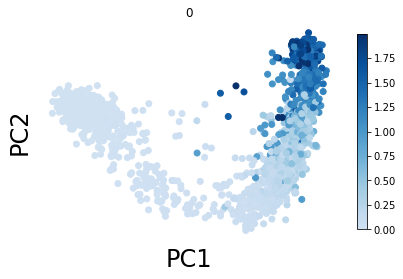

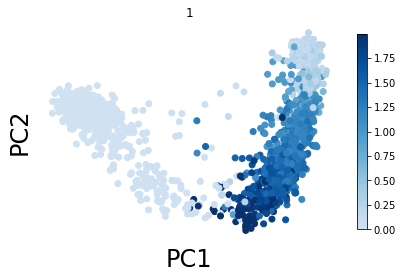

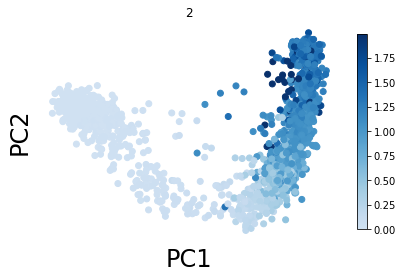

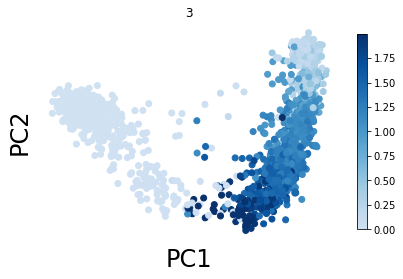

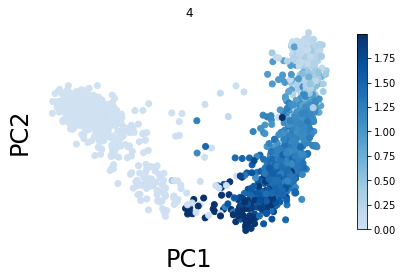

In [154]:
tau = (0,1,2)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(5)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, params=params, n_init=3, perm_theta=True, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)
    
    cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
    fig, ax = plt.subplots(1,1)
    im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
    ax.set_xlabel('PC1',fontsize=24)
    ax.set_ylabel('PC2',fontsize=24)
    ax.set_frame_on(False)
    plt.xticks([]);
    plt.yticks([]);
    plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right
    plt.title(seed)

    elbos['r'+str(seed)] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

In [155]:
for idx in np.sort(list(elbos.keys())):
    print(idx, elbos[idx][-1])

r0 -154.2791833644263
r1 -155.85323851487402
r2 -158.97691971369503
r3 -154.47186244943188
r4 -154.4780258338816


100%|██████████| 6/6 [13:05<00:00, 130.99s/it]


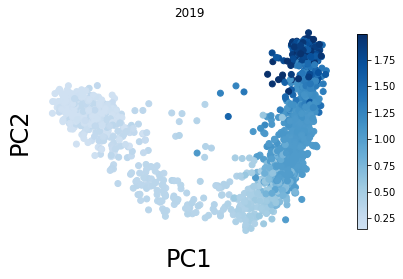

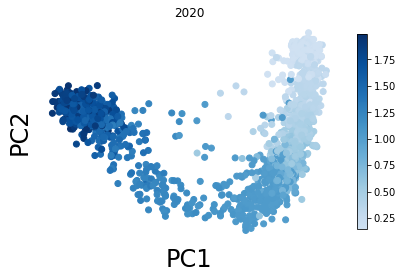

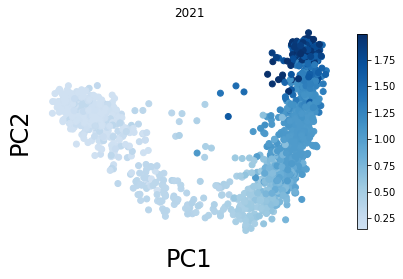

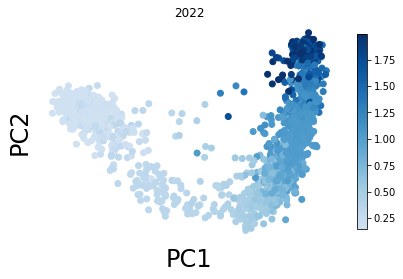

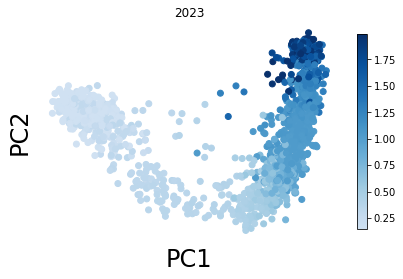

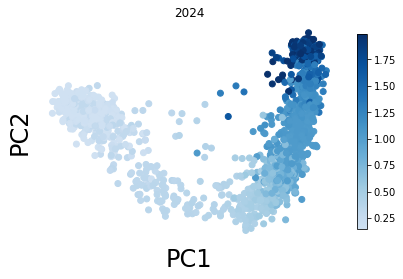

In [220]:
tau=(0,0.3,1,2)
topo = np.array([[0,0,1,2]])
trajs = []
for seed in tqdm(range(5)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, params=params, n_init=3, perm_theta=True, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)
    
    cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
    fig, ax = plt.subplots(1,1)
    im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
    ax.set_xlabel('PC1',fontsize=24)
    ax.set_ylabel('PC2',fontsize=24)
    ax.set_frame_on(False)
    plt.xticks([]);
    plt.yticks([]);
    plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right
    plt.title(seed)

    elbos['r'+str(seed)] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

In [221]:
for idx in np.sort(list(elbos.keys())):
    print(idx, elbos[idx][-1])

r2019 -362.2269250280501
r2020 -362.7365134257887
r2021 -364.33280376348296
r2022 -364.60609376067504
r2023 -362.6908284942015
r2024 -362.7389289770374


#### two_species_ss_tau

100%|██████████| 6/6 [1:03:31<00:00, 635.19s/it]


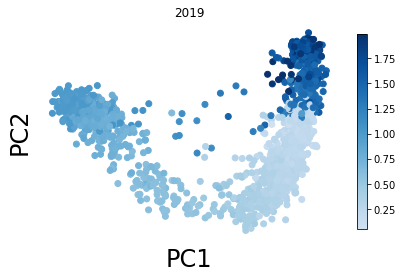

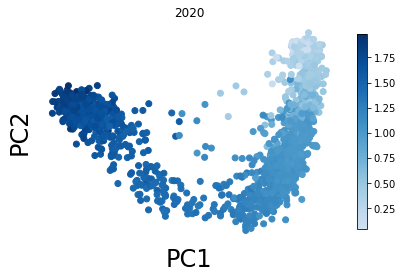

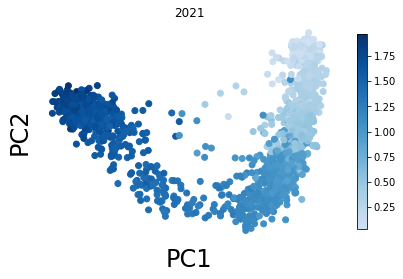

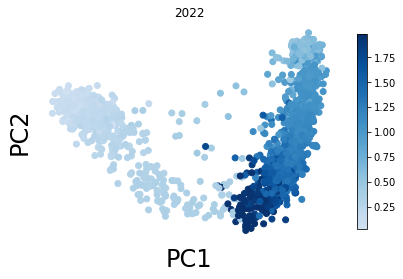

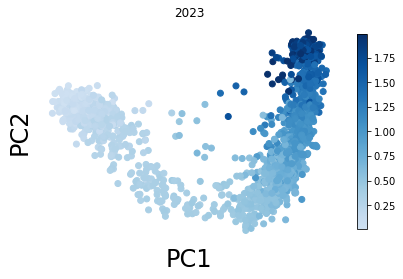

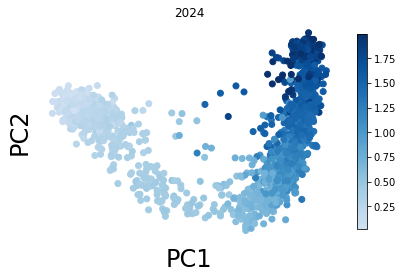

In [222]:
tau=(0,0.3,1,2)
topo = np.array([[0,0,1,2]])
trajs = []
for seed in tqdm(range(2019,2025)):
    traj = Trajectory(topo, tau,  model="two_species_ss_tau", restrictions={}, verbose=0)
    traj = traj.fit(X, params=params, n_init=15, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)
    
    cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
    fig, ax = plt.subplots(1,1)
    im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
    ax.set_xlabel('PC1',fontsize=24)
    ax.set_ylabel('PC2',fontsize=24)
    ax.set_frame_on(False)
    plt.xticks([]);
    plt.yticks([]);
    plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right
    plt.title(seed)

    elbos['r'+str(seed)] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

In [223]:
for idx in np.sort(list(elbos.keys())):
    print(idx, elbos[idx][-1])

r2019 -351.8623949408812
r2020 -353.0101570123224
r2021 -350.65705172866666
r2022 -351.82549973594126
r2023 -350.2467817828985
r2024 -351.8526142577286


100%|██████████| 5/5 [08:12<00:00, 98.56s/it] 


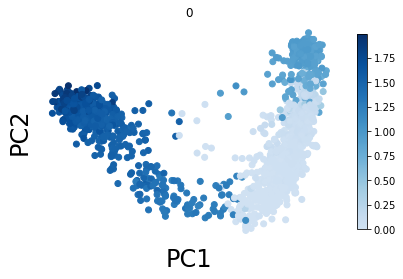

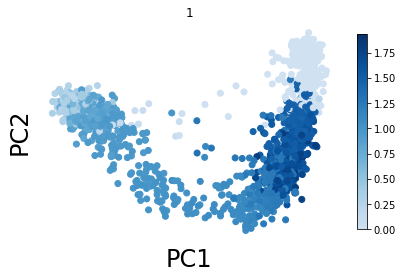

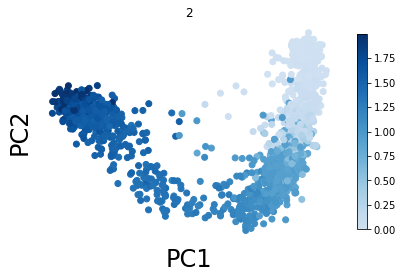

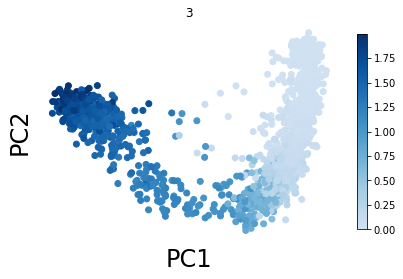

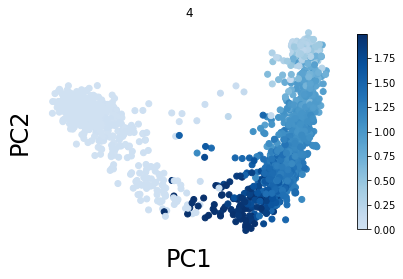

In [23]:
tau=(0,1,2)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(5)):
    traj = Trajectory(topo, tau,  model="two_species_ss_tau", restrictions={}, verbose=0)
    traj = traj.fit(X, params=params, n_init=3, perm_theta=True, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)
    
    cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
    fig, ax = plt.subplots(1,1)
    im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
    ax.set_xlabel('PC1',fontsize=24)
    ax.set_ylabel('PC2',fontsize=24)
    ax.set_frame_on(False)
    plt.xticks([]);
    plt.yticks([]);
    plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right
    plt.title(seed)

    elbos['r'+str(seed)] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

In [25]:
for idx in np.sort(list(elbos.keys())):
    print(idx, elbos[idx][-1])

r0 -358.38233234215943
r1 -355.83525294550293
r2 -351.5183053987486
r3 -356.1761181983822
r4 -358.664177573253


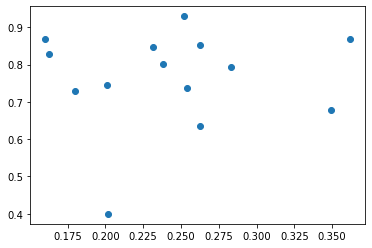

In [73]:
plt.scatter(traj.theta[:,-4],traj.theta[:,-3]);

In [74]:
for traj in trajs:
    L1 = np.abs((traj.theta[:,[1,2]]-traj.theta[:,[0,1]])).sum()
    print(L1)

139.90777764847888
141.35658089112604
131.6540908500464
144.6268887692936
131.0179756937044
129.9477774161096
136.09625769921405


In [75]:
for traj in trajs:
    L2 = np.sum((traj.theta[:,[1,2]]-traj.theta[:,[0,1]])**2)
    print(L2)

6977.29923315419
6713.825648653376
8082.945008539768
7275.658216094471
7640.3340052629155
5779.609111562695
6360.43167146116


## Fine clusters

In [ ]:
print(Clusters)
m=100
t_grids=np.linspace(0,2,m)
weight0 = np.ones((adata.n_obs,m))
for i in Clusters:
    idx = clusters.isin([i])
    weight0[idx,int(i*m/7):int((i+1)*m/7)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]
ax = plot_t(Q0,order_cells=True)

x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list)

label_font = '24'
plt.ylabel("cells", fontsize = label_font);
plt.xlabel("time grids", fontsize = label_font);

In [ ]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=1)
traj = traj.fit(X, Q=Q0, parallel=True, n_threads=2)

In [ ]:
traj.elbos[-1]

In [ ]:
elbos['cf'] = traj.elbos

In [ ]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
plot_phase(traj, plot_idx, gene_list, cell_colors='grey')

In [ ]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,cell_type in enumerate(Clusters):
    idx = adata.obs["Clusters"].isin([cell_type])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

In [ ]:
ax = plot_t(traj.Q[order],l=0,order_cells=False)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list)
ax.set_yticks([])

## Coarse clusters

In [ ]:
Clusters_c = [[0,1],[2,3],[4,5],[6]]
print(Clusters_c)
m=100
t_grids=np.linspace(0,2,m)
weight0 = np.ones((adata.n_obs,m))
for i,cell_type in enumerate(Clusters_c):
    idx = clusters.isin(cell_type)
    weight0[idx,int(i*m/4):int((i+1)*m/4)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]
ax = plot_t(Q0,order_cells=True)

x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list)

label_font = '24'
plt.ylabel("cells", fontsize = label_font);
plt.xlabel("time grids", fontsize = label_font);

In [ ]:
fig, ax = plt.subplots(1,1)
Clusters_c = [[0,1],[2,3],[4,5],[6]]
for i,cell_type in enumerate(Clusters_c):
    idx = clusters.isin(cell_type)
    if i ==3:
        ax.scatter(-x[idx,0],-x[idx,1],c=colors20[i*2]);
    else:
        ax.scatter(-x[idx,0],-x[idx,1],c=(colors20[i*2]+colors20[i*2+1])/2);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [ ]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=1)
traj = traj.fit(X, Q=Q0, parallel=True, n_threads=2)

In [ ]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
traj.compute_AIC(X)

In [ ]:
elbos['cc'] = traj.elbos

In [ ]:
for idx in elbos.keys():
    print(idx, elbos[idx][-1])

In [ ]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,cell_type in enumerate(Clusters):
    idx = adata.obs["Clusters"].isin([cell_type])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj.Q[order],l=0,ax=ax,order_cells=False)
ax.set_yticks([]);

In [ ]:
plot_mask = gene_list.isin(known_marker_genes)
plot_idx = np.arange(len(gene_list))[plot_mask]

gene_list[plot_mask]

plot_phase(traj, plot_idx, gene_list, cell_colors='grey')

plot_y(traj, plot_idx, gene_list, cell_colors='grey')

In [ ]:
plot_mask = gene_list.isin(novel_marker_genes)
plot_idx = np.arange(len(gene_list))[plot_mask]

gene_list[plot_mask]

plot_phase(traj, plot_idx, gene_list, cell_colors='grey')

plot_y(traj, plot_idx, gene_list, cell_colors='grey')

In [ ]:
plot_mask = gene_list.isin(their_genes)
plot_idx = np.arange(len(gene_list))[plot_mask]

gene_list[plot_mask]

plot_phase(traj, plot_idx, gene_list, cell_colors='grey')

plot_y(traj, plot_idx, gene_list, cell_colors='grey')

In [ ]:
plot_mask = gene_list.isin(marker_genes)
plot_idx = np.arange(len(gene_list))[plot_mask]

fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot([0,1,2],traj.theta[j,[-3,0,1]],'-*',color='gray')
for j in plot_idx:
    ax.plot([0,1,2],(traj.theta[j,-3],traj.theta[j,0],traj.theta[j,1]),'-*',color='red')

x_label_list = ['u0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
plt.yscale('log')

## ELBO plot

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(elbos['r'],label="random init",linewidth=6,alpha=0.5);
ax.plot(elbos['cf'],label="fine clusters",linewidth=6,alpha=0.5);
ax.plot(elbos['cc'],label="coarse clusters",linewidth=6,alpha=0.5);
ax.set_yscale('log')
ax.set_xlabel('epoch',fontsize=18)
ax.set_ylabel('relative elbo',fontsize=18)
plt.legend(fontsize=18);
ax.axes.get_yaxis().set_visible(False)

# Marker genes only

In [ ]:
idx = adata.var_names.isin(marker_genes)
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [ ]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=10,epoch=100,parallel=True,n_threads=4,seed=2019)
print(-traj.compute_AIC(X)/2/len(X))

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r2019'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

In [ ]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species",verbose=0)
traj = traj.fit(X,m=100,n_init=10,epoch=100,parallel=True,n_threads=4,seed=2019)
print(-traj.compute_AIC(X)/2/len(X))

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r2019'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

In [ ]:
print(-traj.compute_AIC(X)/2/len(X))

In [ ]:
tau=(0,1,2)
topo = np.array([[0,1]])
for seed in tqdm(range(2020,2030)):
    traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=0)
    traj = traj.fit(X, n_init=10, parallel=True, epoch=100, n_threads=4, seed=seed)

    cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
    fig, ax = plt.subplots(1,1)
    im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
    ax.set_xlabel('PC1',fontsize=24)
    ax.set_ylabel('PC2',fontsize=24)
    ax.set_frame_on(False)
    plt.xticks([]);
    plt.yticks([]);
    plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right
    plt.title(seed)

    print( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] )